# 【適用事例】 畳み込みニューラルネットワーク（CNN）を用いたカラー画像認識

《学修項目》
*   画像データと対応する教師データの読み込み
*   画像データと正解データの表示
*   CNNの構成と学習法の設定
*   CNNの学習と評価
*   単一画像、任意画像の認識

《キーワード》
> TensorFlow、Keras、画像認識、MNIST、畳み込み層、Conv2D、活性化関数、プーリング層、テンソル要素のベクトル化、出力層、ソフトマックス関数、クロスエントロピー誤差、識別精度(accuracy)、エポック(epoch)


## 1. 各種モジュールの読み込みとカラー画像データの読み込み

前述の適用例では、白黒のグレースケール画像（濃淡画像）として数字画像の認識を行ってみたが、ここでは、カラー画像を対象としてCNNを用いた学習と認識を行ってみる。なお、ここで使用するCNNの構造は、画像の入力部分がRGBの3チャンネル画像となる他は、数字認識に用いたCNNの構造とほぼ同じである（本プログラムは、TensorFlowのチュートリアルページ の内容を参考としている）。

> https://www.tensorflow.org/tutorials/images/intro_to_cnns?hl=ja


In [1]:
import tensorflow as tf  #TensorFlowモジュールのインポート
from keras import datasets, layers, models #Kerasモジュール内の関数名をインポート
import matplotlib.pyplot as plt #Matplotlibモジュールのインポート
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data() #カラー画像データの読み込み
train_images, test_images = train_images / 255.0, test_images / 255.0 #各画素値を0から1の値に正規化

170498071/170498071 [==============================] - 4s 0us/step


1行目では、TensorFlowモジュールをインポートし、2行目では、Kerasモジュール内の各種関数を直接呼び出せるように設定、3行目では、描画モジュールであるMatplotlibをインポートしている。4行目は、使用するカラー写真画像データを読み込んでいる。ここで使用するのは、CIFAR-10と呼ばれる画像データベースであり、各画像は10種類の物体（飛行機、車、鳥、猫、鹿、犬、カエル、馬、船、トラック）を撮影した32×32画素のカラー画像である。読み込んだtrain_imagesは学習用データであり、50,000枚の画像からなり、train_labelsはそれらの各画像に対応する正解データ(0から9の数字、0が飛行機、1が車、…、9がトラックに対応する)である。一方、test_imagesは評価用データであり、10,000枚の画像からなり、test_labelsはそれらの各画像に対応する正解データである。そして、最後の5行目では、RGBの各画像の各画素が0から255の輝度値を持っているので、この値を0から1に正規化している。


## 2. 画像データと正解データの表

先ほど読み込んだ学習用の画像データとそれに対応する正解データを表示してみよう。

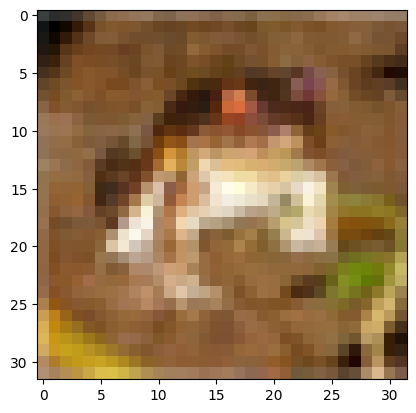

カエル


In [2]:
class_names = ['飛行機', '車', '鳥', '猫', '鹿',
               '犬', 'カエル', '馬', '船', 'トラック']  #画像の識別クラス
plt.imshow(train_images[0])                             #学習用データの最初の画像を指定
plt.show()                                              #画像を画面に表示
print(class_names[train_labels[0][0]])                  #学習用データの最初の画像の正解クラスを表示

先ほど読み込んだ学習用の画像データとそれに対応する正解データを表示してみよう。まず、1行目では、10種類の画像クラスに名前をつけて、class_namesというリストに格納している。2, 3行目では、学習用画像データの最初の画像 train_images[0] (ここで、添え字0が画像番号を示す。2番目の画像はtrain_images[1]である。)を画面に表示している。

最後に4行目で、上記画像データに対応する正解データ train_labels[0][0]のクラス名を表示している。ここで、train_labelsは2次元配列であり、最初の添え字は画像番号を示し、2つ目の添え字は全て0となっている。この画像では「カエル」と表示される。

## 3. CNNの構成

図43に、カラー画像認識に使用する畳み込みニューラルネットワークの構造を示し、この構造を実現するためのプログラムを示す。以下、プログラム行と図を対照しながら、各部の説明をする。

<figure>
<img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-IR/main/B2/figures/fig43.png' alt='CNNの構造' width='700' border='1'>
<figcaption>図43　CNNの構造</figcaption>
</figure>



プログラムのmodel.addメソッドは、ネットワークに各層を追加している。

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))) #畳み込み層：フィルタ数が32、フィルタのサイズが3x3、活性化関数がReLU、入力画像のサイズが32x32画素でカラー画像
model.add(layers.MaxPooling2D((2, 2)))                                           #MAXプーリング：サイズ2x2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))                          #畳み込み層：フィルタ数が64、フィルタのサイズが3x3、活性化関数がReLU
model.add(layers.MaxPooling2D((2, 2)))                                           #MAXプーリング：サイズ2x2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))                          #畳み込み層：フィルタ数が64、フィルタのサイズが3x3、活性化関数がReLU
model.add(layers.Flatten())                                                      #前段の出力（テンソル）の要素値を1列に並べてベクトル化
model.add(layers.Dense(64, activation='relu'))                                   #全結合層：ユニット数が64、活性化関数がReLU
model.add(layers.Dense(10, activation='softmax'))                                #全結合層（出力層）：ユニット数が10、活性化関数がソフトマックス関数
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

```
1  model = models.Sequential()
2  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
```
まず、2行目では、layers.Conv2Dを使って、畳み込み層を追加している。32は、フィルタ数を示し、(3, 3)はフィルタのサイズ、activationは活性化関数の指定（ここでは、ReLUを指定）、input_shapeは入力画像のサイズが32×32画素でカラー画像であることを意味している（カラー画像はR, G, Bの3枚の画像で構成されているので、3チャンネルの画像であると考えられる）。図43で考えると、入力画像について、3×3のフィルタを適用して畳み込みを行い、結果として、30×30の大きさの32チャンネルの画像(行列)を生成していることになる。


```
3  model.add(layers.MaxPooling2D((2, 2)))
```
3行目では、layers.MaxPooling2Dを使って、MAXプーリング層を追加している。引数の(2, 2)はプーリングサイズを意味している。その結果、30×30画素の画像は半分のサイズの15×15画素の画像となる。チャンネル数は32のままである。

```
4  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
5  model.add(layers.MaxPooling2D((2, 2)))
6  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
```
以下同様に、4行目で畳み込み層、5行目でMAXプーリング、6行目で畳み込み層をそれぞれ追加している。図43に示すように、結果として、4×4画素の画像が64枚（64チャンネル）生成されることになる。


```
7  model.add(layers.Flatten())
```
7行目のlayers.Flattenでは、上記で生成したテンソルの要素値を1列に並べてベクトル化する操作を行う。具体的には、4×4の画像が64枚あるので、その画像の各画素を1列に並べることになるので、4×4×64=1,024の数値列（ベクトル）となる。これが、全結合層の入力ベクトルとなる。



```
8  model.add(layers.Dense(64, activation='relu'))
```
8行目のlayers.Denseは、全結合層の追加を意味する。引数の64は、ユニットの個数、activationは活性化関数の種類を示す。よって、図43の下段に示すように、入力層1,024個のユニットから全結合された64個のユニットで構成され、このユニットからの出力には活性化関数としてReLUが適用される。


```
9  model.add(layers.Dense(10, activation='softmax'))
```
9行目も全結合層の追加であり、これが出力層となる。ここでは、画像クラスを表現するために10個のユニットを用意し、活性化関数はソフトマックス関数を指定している。これにより、図43に示すように各ユニットからは、各画像クラスである確率値が出力されることになる（例えば、一番上の出力ユニットからは、入力画像が「飛行機」である確率値が出力される）。


```
10  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
```
最後に10行目のmodel.compileで、最適化アルゴリズムをAdam、誤差関数としてクラス出力に関するクロスエントロピー誤差を採用、学習途中の評価のための尺度として識別精度(accuracy)を指定している。



## 4. CNNの学習と評価

上記の手順で作成したCNNを用いて、学習データについて学習を行うためには、次のようにプログラムを記述する。なお、ここでは、各エポックでの学習済みCNNを用いた評価用データに対する識別率も合わせて表示するため、validation_dataの項目を付加している。


In [4]:
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels)) #学習データの学習と評価データの評価、学習回数は10回

Epoch 1/10
1563/1563 [==============================] - 19s 6ms/step - loss: 1.5084 - accuracy: 0.4498 - val_loss: 1.2508 - val_accuracy: 0.5519
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.1681 - accuracy: 0.5870 - val_loss: 1.1264 - val_accuracy: 0.6026
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0231 - accuracy: 0.6414 - val_loss: 1.0062 - val_accuracy: 0.6464
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9206 - accuracy: 0.6769 - val_loss: 0.9642 - val_accuracy: 0.6681
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8461 - accuracy: 0.7043 - val_loss: 0.9018 - val_accuracy: 0.6909
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7844 - accuracy: 0.7252 - val_loss: 0.8588 - val_accuracy: 0.7022
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7340 - accuracy: 0.7421 - val_loss: 0.8914 - val_accur

ここで、epochsを10としているので、カラー画像全体(50,000枚)を一通り学習する計算を10回繰り返していることになる。各エポックでの学習データ(50,000枚)に対する認識率と評価データ(10,000枚)に対する認識率の経過は次のとおりである。なお、学習時のフィルタの値、バイアス値、重みの値の初期値は乱数によって設定されるため、学習ごとに微妙に結果の値が異なる点に留意されたい。

ここで、accuracyの部分が学習データに対する認識率、val_accuracyの部分が評価データに対する認識率を示す。この結果から、カラー画像について、70%以上の認識率が得られていることがわかる。前述の数字画像認識に比べると、大幅に認識率が低下しているのは、この分類問題が数字認識に比べて難しいことを示している。より精度を上げるためには、CNNの構造や学習方法をさらに見直す必要があるだろう。

## 5. 単一画像の認識

ここでは、評価用の画像データから1枚の画像を選択して、その画像について、学習済みのCNNを使って認識を行ってみよう。

評価データの2番目の画像（船の画像）について、認識を行うプログラムを下記に示す。

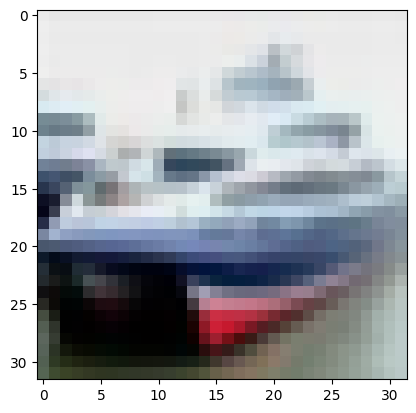

1/1 [==============================] - 0s 190ms/step
[1.3825454e-01 7.8367539e-02 1.5602445e-05 3.3684093e-05 6.3646198e-06
 3.4200016e-07 5.4509655e-08 5.0988237e-06 7.7765328e-01 5.6635668e-03]
船


In [5]:
import numpy as np                            #Numpyモジュールのインポート
image = test_images[1]                        #評価用データの2番目の画像を抽出
plt.imshow(image)                             #学習用データの最初の画像を指定
plt.show()                                    #画像の表示
ex_image = image[np.newaxis, ...]             #imageの配列の次元を1つ増やし、(1,32,32,3)の形式とする
predict_image = model.predict(ex_image)       #学習済みのCNNを使って画像を認識
print(predict_image[0])                       #認識結果の表示
pred_class = predict_image[0].argmax()        #最も大きな確率値を持つクラスの添え字を抽出
print(class_names[pred_class])                #認識されたクラスの表示

2行目で評価用画像データ test_imagesの2番目の画像（添え字「1」が2番目の画像を指す）の情報をimageに代入し、3・4行目で、その画像を表示している。このCNNモデルで認識する場合、画像群の形式が (?, 32, 32, 3)の4次元配列になっている必要がある（?部分は画像の枚数を示す）。現在のimageの画像形式は(32, 32, 3)の3次元配列になっているため、5行目で次元を増やした ex_imageの画像を生成している。これにより、ex_imageの形式は(1, 32, 32, 3)となる。学習したモデルによる認識（推定）には、model.predictを用いる。6行目では、引数に認識したい画像ex_imageを渡して、その画像の認識を行い、結果をpredict_imageに代入している。predict_image は1行10列の2次元配列になっており、その1行目を取り出して表示しているのが7行目である。表示結果を見ると、10個の0から1の実数値が並んでいる。これは、それぞれ、飛行機、車、…、トラックに対する確率値を示している。8行目は、この値の中で、最も大きな値を持つ画像クラスに対応する添え字を取り出し、pred_class変数に代入している。そして、最後の9行目で、その添え字に該当するクラス名を表示している。

ここでは、認識画像が「船」の画像なので、predict_image[0]の9番目の値が最も大きくなり（つまり、船の画像である確率値が最も高くなる）、そのクラス名として「船」が表示されるはずである。

## 6. 任意画像の認識

前述までの画像認識では、CIFAR-10で用意された評価用画像データについての認識を説明してきたが、ここでは、自分で用意した画像を、学習済みのCNNを使って認識してみよう。


まず、認識したい画像（この例では、dog_image.jpgのファイル名で保存されたJPEG画像を対象とする）を個人のGoogleドライブの領域にアップロードしておく。通常、Google Colaboratoryを用いると、そのプログラムファイルは、Googleドライブの「Colab Notebooks」フォルダの下に保存されるので、画像ファイルもこのフォルダの下にアップロードしておくことにする。

Google ColaboratoryからGoogleドライブのファイルを読み込むためには、Googleドライブをマウントする必要がある。この操作は、次のプログラムを実行すればよい（最初に実行するとドライブへのアクセスを許可してよいか聞かれるので、「許可」をする）。

In [6]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Googleドライブからファイル(dog_image.jpg)を読み込んで、その画像について認識を行うプログラムは次のとおりである。


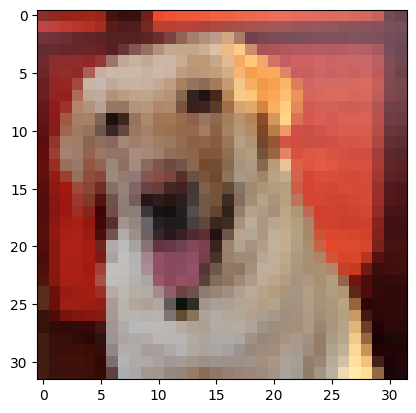

1/1 [==============================] - 0s 20ms/step
犬


In [11]:
from PIL import Image                                                                        #Pillowモジュールの読み込み
orgimg = Image.open('/content/drive/MyDrive/Colab Notebooks/dog_image.jpg').resize((32,32))  #Googleドライブからdog_image.jpgを読み込み、画像サイズを32x32とする
image = np.array(orgimg)/255.0                                                               #Pillow形式からNumPy形式への変換、画素値を0-1に正規化
plt.imshow(image)                                                                            #読み込んだ画像を表示設定
plt.show()                                                                                   #画像の表示
ex_image = image[np.newaxis, ...]                                                            #imageの配列の次元を1つ増やし、(1,32,32,3)の形式とする
predict_image = model.predict(ex_image)                                                      #学習済みのCNNを使って画像を認識
pred_class = predict_image[0].argmax()                                                       #最も大きな確率値を持つクラスの添え字を抽出
print(class_names[pred_class])                                                               #認識されたクラスの表示

このプログラムでは、画像処理用のモジュールとしてPillowを用いる。1行目はそのPillowモジュールのインポートを行っている。2行目は、先ほどアップロードした画像ファイル(dog_image.jpg)を読み込み、画像サイズを32×32画素にリサイズし、orgimgに代入している。ここで、orgimgはPillowモジュールの画像形式となっているため、これをNumPyの形式に変換し、さらに各要素を0から1の値に正規化しているのが3行目である。これにより(32,32,3)形式の3次元配列が生成される。4行目以降の処理は前節で説明した処理と同じである。ここでは、「犬」の画像を読み込ませ、それを認識した結果、「犬」と推定できたことを示している。

以上、任意の画像を読み込んでCNNで認識することが可能となった。教材を学習している方も、是非、認識したい画像を読み込ませて、その認識精度を確かめていただきたい。


# memo